In [1]:
%run imports.ipynb

In [2]:
import dadi
from dadi import Numerics
from dadi import PhiManip
from dadi import Integration
from dadi import Spectrum
import pylab
import sys
import os
import numpy
from datetime import datetime
import Models_2D

In [3]:
pop_ids=["GM", "GW"]

In [4]:
fs_fw = dadi.Spectrum(np.load("dadi/fs_2_pops/GM_GW.npy"), pop_ids = ['GM', 'GW'])
fs_fw

Spectrum([[-- 142068.0 37092.0 ... 0.0 0.0 0.0]
 [39777.0 17181.0 9725.0 ... 0.0 0.0 0.0]
 [14933.0 8036.0 5498.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 2.0 1.0]
 [0.0 0.0 0.0 ... 0.0 2.0 3.0]
 [0.0 0.0 0.0 ... 3.0 8.0 --]], folded=False, pop_ids=['GM', 'GW'])

In [5]:
proj = (fs_fw.sample_sizes[0], fs_fw.sample_sizes[1])
proj

(130, 182)

In [6]:
print("\n\n============================================================================")
print("\nData for site frequency spectrum:\n")
print("Projection: {}".format(proj))
print("Sample sizes: {}".format(fs_fw.sample_sizes))
print("Sum of SFS: {}".format(np.around(fs_fw.S(), 2)))
print("\n============================================================================\n")




Data for site frequency spectrum:

Projection: (130, 182)
Sample sizes: [130 182]
Sum of SFS: 446514.0




In [7]:
def parse_params(param_number, in_params=None, in_upper=None, in_lower=None):
    #--------------------------------------------------------------------------------------
    # function to correctly deal with parameters and bounds, if none were provided, generate them automatically
    
    # Arguments
    # param_number: number of parameters in the model selected (can count in params line for the model)
    # in_params: a list of parameter values 
    # in_upper: a list of upper bound values
    # in_lower: a list of lower bound values
    #--------------------------------------------------------------------------------------
    param_number = int(param_number)
    
    #param set
    if in_params is None:
        params = [1] * param_number
    elif len(in_params) != param_number:
        raise ValueError("Set of input parameters does not contain the correct number of values: {}".format(param_number))
    else:
        params = in_params
        
    #upper bound    
    if in_upper is None:
        upper_bound = [30] * param_number
    elif len(in_upper) != param_number:
        raise ValueError("Upper bound set for parameters does not contain the correct number of values: {}".format(param_number))
    else:
        upper_bound = in_upper
        
    #lower bounds
    if in_lower is None:
        lower_bound = [0.01] * param_number
    elif len(in_lower) != param_number:
        raise ValueError("Lower bound set for parameters does not contain the correct number of values: {}".format(param_number))
    else:
        lower_bound = in_lower
        
    return params, upper_bound, lower_bound

def parse_opt_settings(rounds, reps=None, maxiters=None, folds=None):
    #--------------------------------------------------------------------------------------
    # function to correctly deal with replicate numbers, maxiter and fold args
    
    # Arguments
    # rounds: number of optimization rounds to perform
    # reps: a list of integers controlling the number of replicates in each of three optimization rounds
    # maxiters: a list of integers controlling the maxiter argument in each of three optimization rounds
    # folds: a list of integers controlling the fold argument when perturbing input parameter values
    #--------------------------------------------------------------------------------------
    rounds = int(rounds)
    
    #rep set
    #create scheme where final replicates will be 20, and all previous 10
    if reps is None:
        if rounds >= 2:
            reps_list = [10] * (rounds-1)
            reps_list.insert(len(reps_list),20)
        else:
            reps_list = [10] * rounds
    elif len(reps) != rounds:
        raise ValueError("List length of replicate values does match the number of rounds: {}".format(rounds))
    else:
        reps_list = reps
        
    #maxiters   
    if maxiters is None:
        maxiters_list = [5] * rounds
    elif len(maxiters) != rounds:
        raise ValueError("List length of maxiter values does match the number of rounds: {}".format(rounds))
    else:
        maxiters_list = maxiters
        
    #folds
    #create scheme so if rounds is greater than three, will always end with two fold and then one fold
    if folds is None:
        if rounds >= 3:
            folds_list = [3] * (rounds-2)
            folds_list.insert(len(folds_list),2)
            folds_list.insert(len(folds_list),1)
        elif rounds == 2:
            folds_list = [2] * (rounds-1)
            folds_list.insert(len(folds_list),1)
        else:
            folds_list = [2] * rounds
    elif len(folds) != rounds:
        raise ValueError("List length of fold values does match the number of rounds: {}".format(rounds))
    else:
        folds_list = folds
        
    return reps_list, maxiters_list, folds_list

def collect_results(fs, sim_model, params_opt, roundrep, fs_folded):
    #--------------------------------------------------------------------------------------
    # gather up a bunch of results, return a list = [roundnum_repnum, log-likelihood, AIC, chi^2 test stat, theta, parameter values] 
    
    # Arguments
    # fs: spectrum object name
    # sim_model: model fit with optimized parameters
    # params_opt: list of the optimized parameters
    # fs_folded: a Boolean (True, False) for whether empirical spectrum is folded or not
    #--------------------------------------------------------------------------------------

    #calculate likelihood
    ll = dadi.Inference.ll_multinom(sim_model, fs)
    ll = numpy.around(ll, 2)
    print("\t\t\tLikelihood = {:,}".format(ll))

    #calculate AIC 
    aic = ( -2*( float(ll))) + (2*len(params_opt))
    print("\t\t\tAIC = {:,}".format(aic))

    #calculate theta
    theta = dadi.Inference.optimal_sfs_scaling(sim_model, fs)
    theta = numpy.around(theta, 2)
    print("\t\t\tTheta = {:,}".format(theta))

    #get Chi^2
    scaled_sim_model = sim_model*theta
    if fs_folded is True:
        #calculate Chi^2 statistic for folded
        folded_sim_model = scaled_sim_model.fold()
        chi2 = numpy.sum((folded_sim_model - fs)**2/folded_sim_model)
        chi2 = numpy.around(chi2, 2)
    elif fs_folded is False:
        #calculate Chi^2 statistic for unfolded
        chi2 = numpy.sum((scaled_sim_model - fs)**2/scaled_sim_model)
        chi2 = numpy.around(chi2, 2)
    print("\t\t\tChi-Squared = {:,}".format(chi2))        

    #store key results in temporary sublist, append to larger results list
    temp_results = [roundrep, ll, aic, chi2, theta, params_opt]

    return temp_results

def write_log(outfile, model_name, rep_results, roundrep):
    #--------------------------------------------------------------------------------------
    #reproduce replicate log to bigger log file, because constantly re-written
    
    # Arguments =
    # outfile: prefix for output naming
    # model_name: a label to slap on the output files; ex. "no_mig"
    # rep_results: the list returned by collect_results function: [roundnum_repnum, log-likelihood, AIC, chi^2 test stat, theta, parameter values]
    # roundrep: name of replicate (ex, "Round_1_Replicate_10")
    #--------------------------------------------------------------------------------------
    fh_log = open("{0}.{1}.log.txt".format(outfile, model_name), 'a')
    fh_log.write("\n{}\n".format(roundrep))
    templogname = "{}.log.txt".format(model_name)
    try:
        fh_templog = open(templogname, 'r')
        for line in fh_templog:
            fh_log.write(line)
        fh_templog.close()
    except IOError:
        print("Nothing written to log file this replicate...")
    fh_log.write("likelihood = {}\n".format(rep_results[1]))
    fh_log.write("theta = {}\n".format(rep_results[4]))
    fh_log.write("Optimized parameters = {}\n".format(rep_results[5]))
    fh_log.close()

def Optimize_Routine(fs, pts, outfile, model_name, func, rounds, param_number, fs_folded=True,
                         reps=None, maxiters=None, folds=None, in_params=None,
                         in_upper=None, in_lower=None, param_labels=" "):
    #--------------------------------------------------------------------------------------
    # Mandatory Arguments =
    #(1) fs:  spectrum object name
    #(2) pts: grid size for extrapolation, list of three values
    #(3) outfile:  prefix for output naming
    #(4) model_name: a label to slap on the output files; ex. "no_mig"
    #(5) func: access the model function from within 'moments_optimize.py' or from a separate python model script, ex. Models_2D.no_mig
    #(6) rounds: number of optimization rounds to perform
    #(7) param_number: number of parameters in the model selected (can count in params line for the model)
    #(8) fs_folded: A Boolean value (True or False) indicating whether the empirical fs is folded (True) or not (False). Default is True.

    # Optional Arguments =
    #(9) reps: a list of integers controlling the number of replicates in each of three optimization rounds
    #(10) maxiters: a list of integers controlling the maxiter argument in each of three optimization rounds
    #(11) folds: a list of integers controlling the fold argument when perturbing input parameter values
    #(12) in_params: a list of parameter values 
    #(13) in_upper: a list of upper bound values
    #(14) in_lower: a list of lower bound values
    #(15) param_labels: list of labels for parameters that will be written to the output file to keep track of their order
    #--------------------------------------------------------------------------------------

    #call function that determines if our params and bounds have been set or need to be generated for us
    params, upper_bound, lower_bound = parse_params(param_number, in_params, in_upper, in_lower)

    #call function that determines if our replicates, maxiter, and fold have been set or need to be generated for us
    reps_list, maxiters_list, folds_list = parse_opt_settings(rounds, reps, maxiters, folds)
    
    print("\n\n============================================================================"
              "\nModel {}\n============================================================================\n\n".format(model_name))

    #start keeping track of time it takes to complete optimizations for this model
    tbr = datetime.now()
    
    # We need an output file that will store all summary info for each replicate, across rounds
    outname = "{0}.{1}.optimized.txt".format(outfile, model_name)
    with open(outname, 'a') as fh_out:
        fh_out.write("Model\tReplicate\tlog-likelihood\tAIC\tchi-squared\ttheta\toptimized_params({})\n".format(param_labels))
        
    #Create list to store sublists of [roundnum_repnum, log-likelihood, AIC, chi^2 test stat, theta, parameter values] for every replicate
    results_list = []
    
    #for every round, execute the assigned number of replicates with other round-defined args (maxiter, fold, best_params)
    rounds = int(rounds)
    for r in range(rounds):
        print("\tBeginning Optimizations for Round {}:".format(r+1))
       
        #make sure first round params are assigned (either user input or auto generated)
        if r == int(0):
            best_params = params
        #and that all subsequent rounds use the params from a previous best scoring replicate
        else:
            best_params = results_list[0][5]

        #perform an optimization routine for each rep number in this round number
        for rep in range(1, (reps_list[r]+1) ):
            print("\n\t\tRound {0} Replicate {1} of {2}:".format(r+1, rep, (reps_list[r])))
            
            #keep track of start time for rep
            tb_rep = datetime.now()
            
            #create an extrapolating function 
            func_exec = dadi.Numerics.make_extrap_log_func(func)
            
            #perturb starting parameters
            params_perturbed = dadi.Misc.perturb_params(best_params, fold=folds_list[r],
                                                            upper_bound=upper_bound, lower_bound=lower_bound)
            
            print("\n\t\t\tStarting parameters = [{}]".format(", ".join([str(numpy.around(x, 6)) for x in params_perturbed])))
            
            #optimize from perturbed parameters
            params_opt = dadi.Inference.optimize_log_fmin(params_perturbed, fs, func_exec, pts,
                                                              lower_bound=lower_bound, upper_bound=upper_bound,
                                                              verbose=1, maxiter=maxiters_list[r],
                                                              output_file = "{}.log.txt".format(model_name))
            
            print("\t\t\tOptimized parameters =[{}]\n".format(", ".join([str(numpy.around(x, 6)) for x in params_opt[0]])))
            
            #simulate the model with the optimized parameters
            sim_model = func_exec(params_opt[0], fs.sample_sizes, pts)

            #collect results into a list using function above - [roundnum_repnum, log-likelihood, AIC, chi^2 test stat, theta, parameter values]
            roundrep = "Round_{0}_Replicate_{1}".format(r+1, rep)
            rep_results = collect_results(fs, sim_model, params_opt[0], roundrep, fs_folded)
            
            #reproduce replicate log to bigger log file, because constantly re-written
            write_log(outfile, model_name, rep_results, roundrep)
            
            #append results from this sim to larger list
            results_list.append(rep_results)
            
            #write all this info to our main results file
            with open(outname, 'a') as fh_out:
                #join the param values together with commas
                easy_p = ",".join([str(numpy.around(x, 4)) for x in rep_results[5]])
                fh_out.write("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\n".format(model_name, rep_results[0],
                                                                              rep_results[1], rep_results[2],
                                                                              rep_results[3], rep_results[4],
                                                                              easy_p))

            #calculate elapsed time for replicate
            tf_rep = datetime.now()
            te_rep = tf_rep - tb_rep
            print("\n\t\t\tReplicate time: {0} (H:M:S)\n".format(te_rep))

        #Now that this round is over, sort results in order of likelihood score
        #we'll use the parameters from the best rep to start the next round as the loop continues
        results_list.sort(key=lambda x: float(x[1]), reverse=True)
        print("\n\t----------------------------------------------\n"
                  "\tBest replicate: {0}\n"
                  "\t\tLikelihood = {1:,}\n\t\tAIC = {2:,}\n"
                  "\t\tChi-Squared = {3:,}\n\t\tParams = [{4}]\n"
                  "\t----------------------------------------------\n\n".format(results_list[0][0],
                                                                              results_list[0][1],
                                                                              results_list[0][2],
                                                                              results_list[0][3],
                                                                              ", ".join([str(numpy.around(x, 4)) for x in rep_results[5]])))

    #Now that all rounds are over, calculate elapsed time for the whole model
    tfr = datetime.now()
    ter = tfr - tbr
    print("\nAnalysis Time for Model '{0}': {1} (H:M:S)\n\n"
              "============================================================================".format(model_name, ter))

    #cleanup file
    os.remove("{}.log.txt".format(model_name))


In [8]:
prefix = "_".join(pop_ids)

In [9]:
pts = [proj[0] + 10, proj[0] + 20, proj[0] + 30]
pts

[140, 150, 160]

In [10]:
rounds = 4

In [11]:
reps = [10,20,30,40]
maxiters = [3,5,10,15]
folds = [3,2,2,1]

In [12]:
fs_folded = False

In [ ]:
Optimize_Routine(fs_fw, pts, prefix, "sec_contact_asym_mig_size", Models_2D.sec_contact_asym_mig_size, rounds, 8, fs_folded=fs_folded,
                                        reps=reps, maxiters=maxiters, folds=folds, param_labels = "nu1a, nu2a, nu1b, nu2b, m12, m21, T1, T2")



Model sec_contact_asym_mig_size


	Beginning Optimizations for Round 1:

		Round 1 Replicate 1 of 10:

			Starting parameters = [4.59167, 0.395364, 3.165227, 3.367333, 0.751804, 5.908105, 2.354943, 4.507739]


			Optimized parameters =[4.59167, 0.395364, 3.165227, 3.578083, 0.751804, 5.908105, 2.354943, 4.507739]



			Likelihood = -165,599.37
			AIC = 331,214.74
			Theta = 15,005.41
			Chi-Squared = 296,538.48

			Replicate time: 0:13:16.468584 (H:M:S)


		Round 1 Replicate 2 of 10:

			Starting parameters = [3.484419, 1.97698, 3.665723, 0.302331, 0.139227, 6.770782, 1.275282, 7.225726]
			Optimized parameters =[3.566936, 2.002407, 3.756104, 0.340748, 0.134174, 7.017999, 1.28111, 7.498692]

			Likelihood = -586,974.28
			AIC = 1,173,964.56
			Theta = 19,983.99
			Chi-Squared = 2,671,553.74

			Replicate time: 0:25:20.617467 (H:M:S)


		Round 1 Replicate 3 of 10:

			Starting parameters = [0.343533, 0.312176, 0.746951, 0.413036, 5.612767, 0.573346, 0.221982, 2.27303]


			Optimized parameters =[0.343533, 0.312176, 0.746951, 0.413036, 6.118372, 0.573346, 0.221982, 2.27303]



			Likelihood = -460,500.96
			AIC = 921,017.92
			Theta = 80,254.16
			Chi-Squared = 1,486,726.6

			Replicate time: 0:06:19.345181 (H:M:S)


		Round 1 Replicate 4 of 10:

			Starting parameters = [4.694848, 0.511175, 5.932198, 0.15006, 4.127129, 0.222739, 0.756072, 0.520474]


			Optimized parameters =[4.832974, 0.504784, 6.133572, 0.1814, 4.238298, 0.216554, 0.752118, 0.51414]



			Likelihood = -1,041,754.73
			AIC = 2,083,525.46
			Theta = 32,701.33
			Chi-Squared = 9,315,303.3

			Replicate time: 0:01:34.817251 (H:M:S)


		Round 1 Replicate 5 of 10:

			Starting parameters = [0.380193, 2.378742, 2.482152, 0.199694, 1.413668, 3.239633, 0.688159, 3.095954]
			Optimized parameters =[0.373362, 2.417708, 2.524825, 0.2346, 1.422874, 3.311826, 0.683354, 3.162255]

			Likelihood = -706,243.92
			AIC = 1,412,503.84
			Theta = 33,200.36
			Chi-Squared = 3,536,109.77

			Replicate time: 0:05:36.955587 (H:M:S)


		Round 1 Replicate 6 of 10:

			Starting parameters = [0.524333, 0.497846, 0.18364, 0.295658, 0.851086, 0.202951, 4.476528, 2.402501]
			Optimized parameters =[0.518024, 0.491378, 0.177896, 0.333972, 0.848517, 0.196972, 4.604118, 2.442311]

			Likelihood = -958,929.71
			AIC = 1,917,875.42
			Theta = 91,387.01
			Chi-Squared = 15,612,293.19

			Replicate time: 0:03:06.429427 (H:M:S)


		Round 1 Replicate 7 of 10:

			Starting parameters = [0.16468, 1.162444, 1.

			Optimized parameters =[0.159203, 1.165729, 1.297502, 7.404078, 0.148354, 1.581376, 0.141597, 0.206368]



			Likelihood = -331,575.75
			AIC = 663,167.5
			Theta = 25,776.43
			Chi-Squared = 1,581,355.83

			Replicate time: 0:00:35.056022 (H:M:S)


		Round 1 Replicate 8 of 10:

			Starting parameters = [0.836176, 1.470097, 0.353137, 2.379782, 4.811212, 1.904168, 5.192639, 0.468443]


			Optimized parameters =[0.833375, 1.480756, 0.346311, 2.418784, 4.955035, 1.927302, 4.40402, 0.46183]



			Likelihood = -389,686.25
			AIC = 779,388.5
			Theta = 26,151.01
			Chi-Squared = 1,035,988.19

			Replicate time: 0:02:12.634281 (H:M:S)


		Round 1 Replicate 9 of 10:

			Starting parameters = [5.094323, 3.26736, 0.990694, 7.476458, 0.135489, 0.49036, 0.307505, 0.583581]
			Optimized parameters =[5.252238, 3.340706, 0.99052, 7.76386, 0.165468, 0.483851, 0.300781, 0.577717]

			Likelihood = -421,626.04
			AIC = 843,268.08
			Theta = 17,351.91
			Chi-Squared = 2,293,252.08

			Replicate time: 0:00:29.114732 (H:M:S)


		Round 1 Replicate 10 of 10:

			Starting parameters = [0.131328, 0.131329, 0.886993, 1.080201, 0.983603, 0.25684, 0.469131, 0.345818]
			Optimized parameters =[0.126423, 0.126424, 0.885, 1.081765, 0.983298, 0.294236, 0.46252, 0.339001]

			Likelihood = -513,142.94
			AIC = 1,026,301.88
			Theta = 52,492.8
			Chi-Squared = 2,370,632.05

			Replicate time: 0:00:57.460621 (H:M:S)


	----------------------------------------------
	Best replicate: Round_1_Replicate_1
		Lik

			Optimized parameters =[9.325969, 0.855118, 2.875985, 2.949258, 0.195016, 6.837115, 0.790407, 2.700205]



			Likelihood = -157,572.48
			AIC = 315,160.96
			Theta = 19,098.54
			Chi-Squared = 287,960.94

			Replicate time: 0:10:50.702391 (H:M:S)


		Round 2 Replicate 2 of 20:

			Starting parameters = [4.777429, 0.500664, 7.186287, 4.923472, 1.835087, 2.829993, 0.731648, 3.590399]


			Optimized parameters =[4.777429, 0.500664, 7.186287, 5.331937, 1.835087, 2.829993, 0.731648, 3.590399]



			Likelihood = -124,257.46
			AIC = 248,530.92
			Theta = 8,547.84
			Chi-Squared = 261,572.26

			Replicate time: 0:05:59.249339 (H:M:S)


		Round 2 Replicate 3 of 20:

			Starting parameters = [1.271421, 0.512004, 8.601092, 3.269889, 2.842623, 7.288305, 8.325787, 3.008412]


			Optimized parameters =[1.277158, 0.505617, 8.955225, 3.34334, 2.898855, 7.564858, 6.7357, 3.071186]



			Likelihood = -164,055.98
			AIC = 328,127.96
			Theta = 8,272.96
			Chi-Squared = 388,699.43

			Replicate time: 0:15:25.483993 (H:M:S)


		Round 2 Replicate 4 of 20:

			Starting parameters = [9.119617, 0.373542, 8.488983, 2.428384, 0.329409, 9.176469, 8.953838, 3.814913]


			Optimized parameters =[9.505526, 0.366708, 8.836325, 2.469119, 0.322622, 9.565898, 7.191315, 3.911897]



			Likelihood = -209,446.56
			AIC = 418,909.12
			Theta = 8,297.55
			Chi-Squared = 504,091.49

			Replicate time: 0:24:24.605658 (H:M:S)


		Round 2 Replicate 5 of 20:

			Starting parameters = [4.550021, 0.30866, 4.348544, 4.042117, 2.355414, 11.19331, 2.481783, 8.44462]


			Optimized parameters =[4.809618, 0.295655, 4.246763, 4.254256, 2.344209, 12.228482, 2.303257, 7.93294]



			Likelihood = -152,093.26
			AIC = 304,202.52
			Theta = 11,704.57
			Chi-Squared = 284,213.3

			Replicate time: 0:56:15.965026 (H:M:S)


		Round 2 Replicate 6 of 20:

			Starting parameters = [5.097496, 0.73869, 3.026884, 3.540373, 1.156608, 4.653458, 2.769941, 2.617537]


			Optimized parameters =[5.051489, 0.730542, 3.152175, 3.708137, 1.162786, 4.923008, 2.688484, 2.577266]



			Likelihood = -163,615.51
			AIC = 327,247.02
			Theta = 14,173.5
			Chi-Squared = 298,578.69

			Replicate time: 0:07:57.939693 (H:M:S)


		Round 2 Replicate 7 of 20:

			Starting parameters = [1.272054, 0.328845, 10.140264, 1.974664, 0.791809, 15.135371, 1.522696, 1.676852]


			Optimized parameters =[1.272054, 0.328845, 10.140264, 1.974664, 0.791809, 17.337749, 1.522696, 1.676852]



			Likelihood = -114,209.93
			AIC = 228,435.86
			Theta = 11,329.88
			Chi-Squared = 303,375.28

			Replicate time: 0:14:51.235748 (H:M:S)


		Round 2 Replicate 8 of 20:

			Starting parameters = [8.303088, 0.927667, 8.27558, 9.846255, 0.726808, 14.804951, 7.198878, 1.643516]


			Optimized parameters =[8.639237, 0.926362, 8.61008, 10.277676, 0.722473, 11.307492, 7.470309, 1.658898]



			Likelihood = -106,513.92
			AIC = 213,043.84
			Theta = 7,508.75
			Chi-Squared = 716,858.33

			Replicate time: 0:14:43.445962 (H:M:S)


		Round 2 Replicate 9 of 20:

			Starting parameters = [2.993745, 0.235074, 1.423362, 2.711487, 1.343562, 1.692739, 0.754042, 13.604272]


			Optimized parameters =[2.993745, 0.235074, 1.423362, 2.850151, 1.343562, 1.692739, 0.754042, 13.604272]



--------------------------------------------
Summarize

In [16]:
os.chdir("output_files/sec_contact/") 
  
print("Directory changed") 

Directory changed


In [17]:
'''
usage: python Summarize_Outputs.py [full path to directory with results files]

example: python Summarize_Outputs.py users/dan/moments_analyses/results/

The purpose of this script is to make sense of the results files
that are produced after optimizations have been run on multiple
models, as there will be an output file for every model included
that is filled with many replicates across several rounds.

Two summary files will be produced:
1. Results_Summary_Extended.txt
    This contains the top five replicates for each results file, with all the information
    including: "Model"	"Replicate"	"log-likelihood"	"AIC"	"chi-squared"	"theta"	"optimized_params"

2. Results_Summary_Short.txt
    This is essentially a simplified version of the above file, and only contains the
    top scoring replicate per model and it is already sorted in order of AIC.

You should probably inspect that the top-scoring replicates were ERROR-FREE. 
Often errors are logged on screen and log-likelihoods are still produced.

-------------------------
Written for Python 2.7 and 3.7
No dependencies
-------------------------

Daniel Portik
daniel.portik@gmail.com
https://github.com/dportik
Updated September 2019
'''

#===========================================================================
file_dir = "../sec_contact/"
os.chdir(file_dir)

#check if summary files already exist in output directory
results = sorted([os.path.abspath(f) for f in os.listdir(file_dir) if f.startswith("Results_Summary")])
if results:
    raise ValueError("\n\n\nWARNING: Summary files are already located in the directory specified."
                         " Please remove them before running this script.\n\n")
    

#initiate empty lists that we will fill with summary information
summary_list = []
simple_list = []

#list comprehension to find output files
flist = sorted([os.path.abspath(f) for f in os.listdir(file_dir) if f.endswith("optimized.txt")])

#do tasks depending on whether files located or not
if flist:
    print("\n\nFound {} output files to summarize:".format(len(flist)))
    for f in flist:
        print("\t{}".format(f.split('/')[-1]))
else:
    print("\n\nFound {} output files to summarize!\n\n".format(len(flist)))
    print("Please check to make sure the output files end with '.optimized.txt' and are"
              "located in the directory specified:\n\t{}".format(file_dir))

#iterate over output files
for f in flist:
    print("\nExtracting contents from: {}".format(f.split('/')[-1]))
    #content list items will have order: "Model"	"Replicate"	"log-likelihood"	"AIC"	"chi-squared"	"theta"	"optimized_params(xxx)"
    with open(f, 'r') as fh:
        lines = [line.strip().split('\t') for line in fh if not line.startswith("Model")]
    #strict filtering: sublists must have 7 elements and not contain any "nan" entries
    content = [l for l in lines if len(l) == 7 and "nan" not in l]
    if len(lines) == len(content):
        print("\tFound {} total replicates.".format(len(lines)))
    else:
        print("\tFound {} row entries.".format(len(lines)))
        print("\tRemoved {} row entries due to presence of 'nan' values or incomplete data.".format(len(lines)-len(content)))
        
    #let's sort all the rows by AIC, lowest to highest
    content.sort(key=lambda x: float(x[3]))
        
    #add top five entries to summary list
    for i in content[:5]:
        summary_list.append(i)
        
    #add top entry to easy list
    simple_list.append(content[0])
   
#make sure results are actually in lists
if simple_list and summary_list:
    
    #sort the list containing only the top entry for each model by order of AIC
    simple_list.sort(key=lambda x: float(x[3]))

    #create output file 1
    out1 = "Results_Summary_Extended.txt"
    with open(out1, 'a') as fh:
        #write tab-delimited file with extended results
        fh.write("Model\tReplicate\tlog-likelihood\tAIC\tchi-squared\ttheta\toptimized_params\n")
        for row in summary_list:
            for val in row:
                fh.write("{}\t".format(val))
            fh.write("\n")

    #create output file 2
    out2 = "Results_Summary_Short.txt"
    with open(out2, 'a') as fh:
        #write tab-delimited file with simplified results
        fh.write("Model\tReplicate\tlog-likelihood\tAIC\tchi-squared\ttheta\toptimized_params\n")
        for row in simple_list:
            for val in row:
                fh.write("{}\t".format(val))
            fh.write("\n")

    print("\n\nSummary files '{0}' and '{1}' have been written to: \n\t{2}\n\n".format(out1, out2, file_dir))

else:
    print("\n\nNo results were written!\n\n")




Found 1 output files to summarize:
	GM_GW.sec_contact_asym_mig.optimized.txt

Extracting contents from: GM_GW.sec_contact_asym_mig.optimized.txt
	Found 100 row entries.
	Removed 1 row entries due to presence of 'nan' values or incomplete data.


Summary files 'Results_Summary_Extended.txt' and 'Results_Summary_Short.txt' have been written to: 
	../sec_contact/




In [18]:
pd.read_csv("Results_Summary_Extended.txt", sep = "\t")

,Model,Replicate,log-likelihood,AIC,chi-squared,theta,optimized_params
sec_contact_asym_mig,Round_4_Replicate_17,-21780.01,43572.02,40129.46,8739.95,"1.1258,21.2238,28.2526,0.5488,0.9698,0.2225",NaN
sec_contact_asym_mig,Round_4_Replicate_12,-21815.91,43643.82,42539.42,9237.27,"1.425,19.8704,23.6051,0.3832,0.7827,0.3152",NaN
sec_contact_asym_mig,Round_4_Replicate_37,-22109.71,44231.42,48496.79,7444.41,"1.5311,24.2985,22.1332,0.3457,1.1208,0.358",NaN
sec_contact_asym_mig,Round_4_Replicate_1,-22256.82,44525.64,46714.29,7301.60,"1.4518,24.084,23.1261,0.2603,1.3692,0.2218",NaN
sec_contact_asym_mig,Round_4_Replicate_25,-22353.98,44719.96,43353.15,8547.80,"1.9233,21.2819,17.32,0.1985,0.8415,0.3525",NaN


In [19]:
pd.read_csv("Results_Summary_Short.txt", sep = "\t")

,Model,Replicate,log-likelihood,AIC,chi-squared,theta,optimized_params
sec_contact_asym_mig,Round_4_Replicate_17,-21780.01,43572.02,40129.46,8739.95,"1.1258,21.2238,28.2526,0.5488,0.9698,0.2225",NaN


----------------------------
Plotting model

In [20]:
file_dir = '../../'
os.chdir(file_dir)

In [21]:
import Plotting_Functions

In [22]:
def sec_contact_asym_mig(params, ns, pts):
    """
    Split with no gene flow, followed by period of asymmetrical gene flow.

    nu1: Size of population 1 after split.
    nu2: Size of population 2 after split.
    m12: Migration from pop 2 to pop 1 (2*Na*m12).
    m21: Migration from pop 1 to pop 2.
    T1: The scaled time between the split and the secondary contact (in units of 2*Na generations).
    T2: The scaled time between the secondary contact and present.
    """
    nu1, nu2, m12, m21, T1, T2 = params

    xx = Numerics.default_grid(pts)
    
    phi = PhiManip.phi_1D(xx)
    phi = PhiManip.phi_1D_to_2D(xx, phi)

    phi = Integration.two_pops(phi, xx, T1, nu1, nu2, m12=0, m21=0)

    phi = Integration.two_pops(phi, xx, T2, nu1, nu2, m12=m12, m21=m21)

    fs = Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

In [24]:
emp_params = [1.1258,21.2238,28.2526,0.5488,0.9698,0.2225]

#**************
#Fit the model using these parameters and return the model SFS.
model_fit = Plotting_Functions.Fit_Empirical(fs_fw, pts, prefix, "sec_contact_asym_mig", sec_contact_asym_mig, emp_params, fs_folded=False)

Fitting model 'sec_contact_asym_mig' to empirical data...

Input parameters = [1.1258, 21.2238, 28.2526, 0.5488, 0.9698, 0.2225]



			Likelihood = -21,780.15
			AIC = 43,572.3
			Theta = 8,739.99
			Chi-Squared = 40,132.46

Creating plots



In [25]:
def Plot_2d(fs, model_fit, model_name, outfile, vmin_val=None):
    #Routine for plotting with 2D jsfs
    fig = pylab.figure(num = 1, figsize = (15,10))
    fig.clear()
    if vmin_val is None:
        dadi.Plotting.plot_2d_comp_multinom(model_fit, fs, resid_range = 3)
    else:
        dadi.Plotting.plot_2d_comp_multinom(model_fit, fs, resid_range = 3, vmin = vmin_val)
    print('\nPlotting {0}_{1}.pdf'.format(outfile, model_name))
    print("\nNOTE - CLOSE PLOT TO ADVANCE.")
    outname = '{0}_{1}.pdf'.format(outfile, model_name)
    fig.savefig(outname)

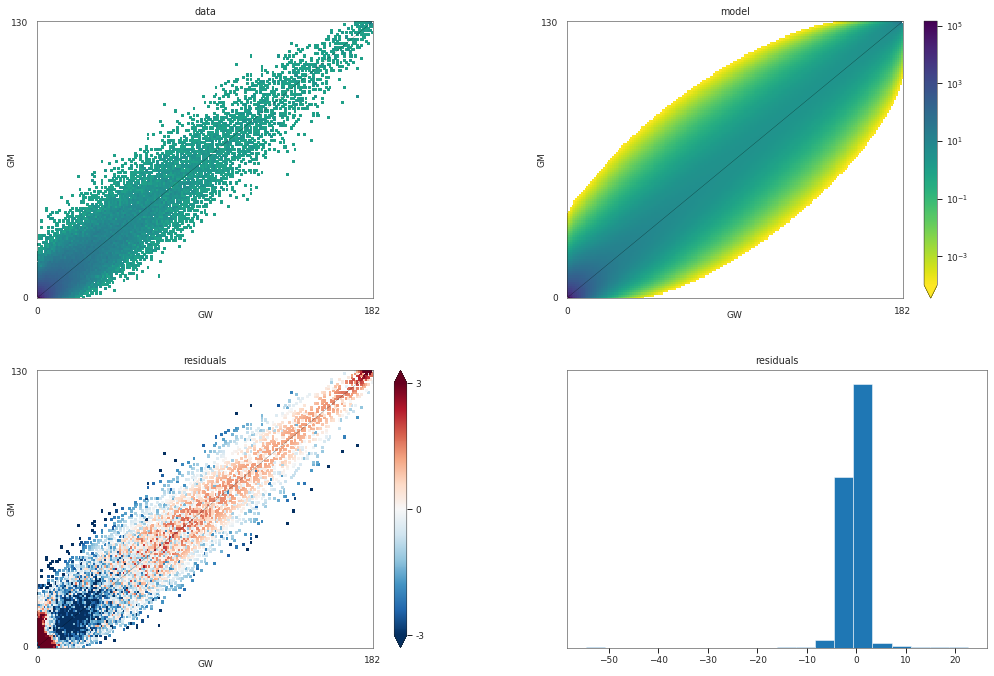


Plotting sec_contact_asym_mig_GM_GW.pdf

NOTE - CLOSE PLOT TO ADVANCE.


In [27]:
Plot_2d(fs_fw, model_fit, prefix, "sec_contact_asym_mig", vmin_val=0.0001)